In [567]:
import numpy as np
import matplotlib.pyplot as plt
from hera_cal import redcal
from hera_cal.io import HERAData
import glob
from pyuvdata import UVData
from pyuvdata import utils as uvutils
from matplotlib.colors import LogNorm
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
from astropy.time import Time

%matplotlib inline

In [264]:
# Look at https://github.com/HERA-Team/hera_qm/blob/master/hera_qm/ant_metrics.py
# Try to understand these ant_metrics and create my own
# Create plots of these with the already loaded data here
# Try to recreate Danny's assessment of which antennas are bad


## from Danny:
# Until we get another set we trust, I recommend this one to you.
# The date was August 8, JD 2458701.3
# Bad antennas: 89, 106, 107, 108, 124, 125, 126

# Data are in the NRAO librarian. Note that they are not associated with a "session ID". I searched by filename to find the raw data files.

In [310]:
### Read in data
uv = UVData()
uv.read('data/2458701/zen.2458701.32550.HH.uvh5')
print(uv.x_orientation)

print('Included antenna numbers are:')
print(uv.antenna_numbers)
print('Visibility data has shape:')
print('(Nblts, Nspws, Nfreqs, Npols)')
print(np.shape(uv.data_array))
dat = uv.get_data(1,2,'xx')
print(np.shape(dat[:,15]))
print(len(uv.time_array)/len(uv.antenna_numbers))

NORTH
Included antenna numbers are:
[  0   1   2  11  12  13  14  23  24  25  26  39  89 106 107 108 124 125
 126]
Visibility data has shape:
(Nblts, Nspws, Nfreqs, Npols)
(3990, 1, 1536, 4)
(21,)
210.0


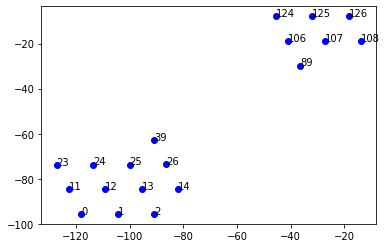

In [588]:
plotAntennaPositions(uv)

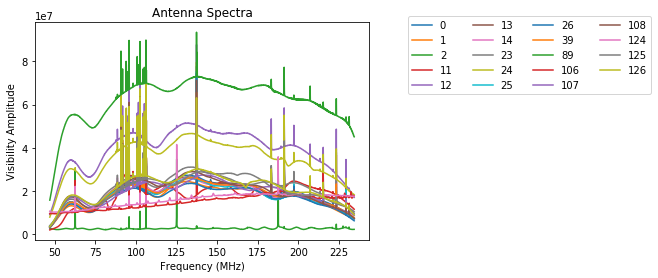

In [592]:
plotSpectra(uv)

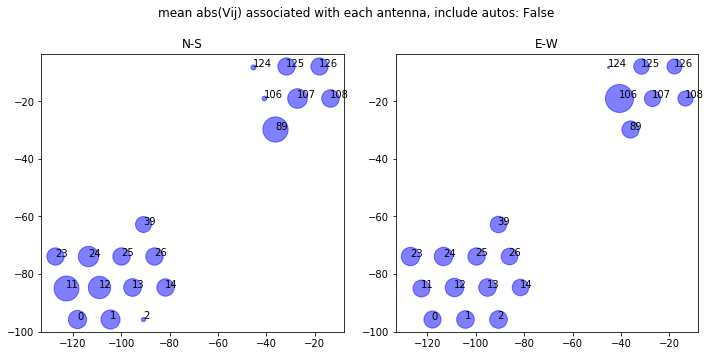

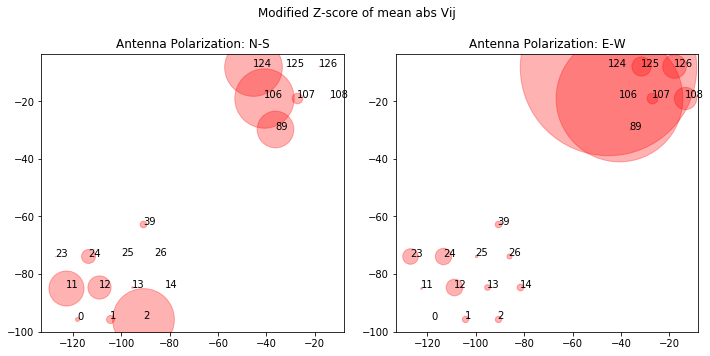

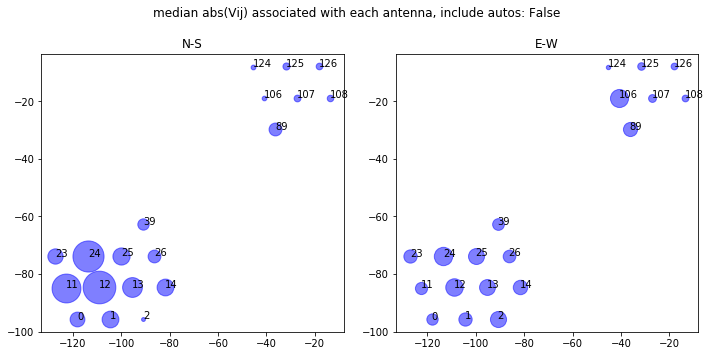

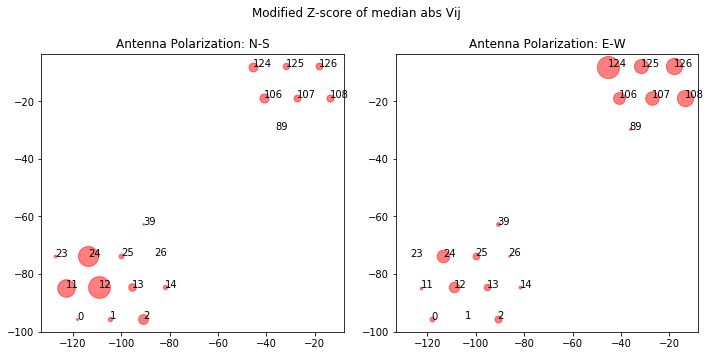

In [579]:
##### BUBBLE PLOTS ######

plotBubbles_antPol(uv,'mean',marker='bo')
plotBubbles_zscore_antPol(uv,'mean',marker='ro',alpha=0.3)
plotBubbles_antPol(uv,'median',marker='bo',normalize=True)
plotBubbles_zscore_antPol(uv,'median',marker='ro')

invalid value encountered in double_scalars


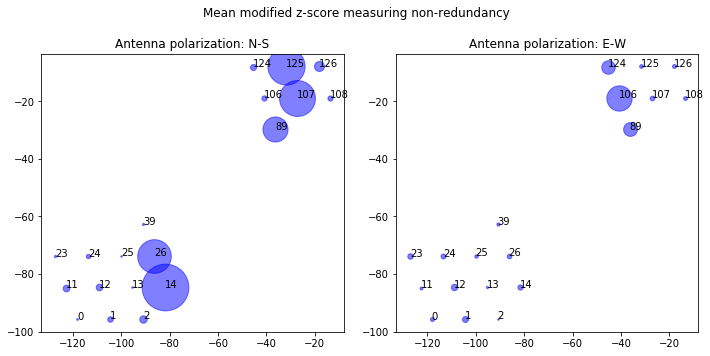

In [580]:
plotBubbles_redundancy(uv)
#plotBubbles_redundancy(uv,pol=False)

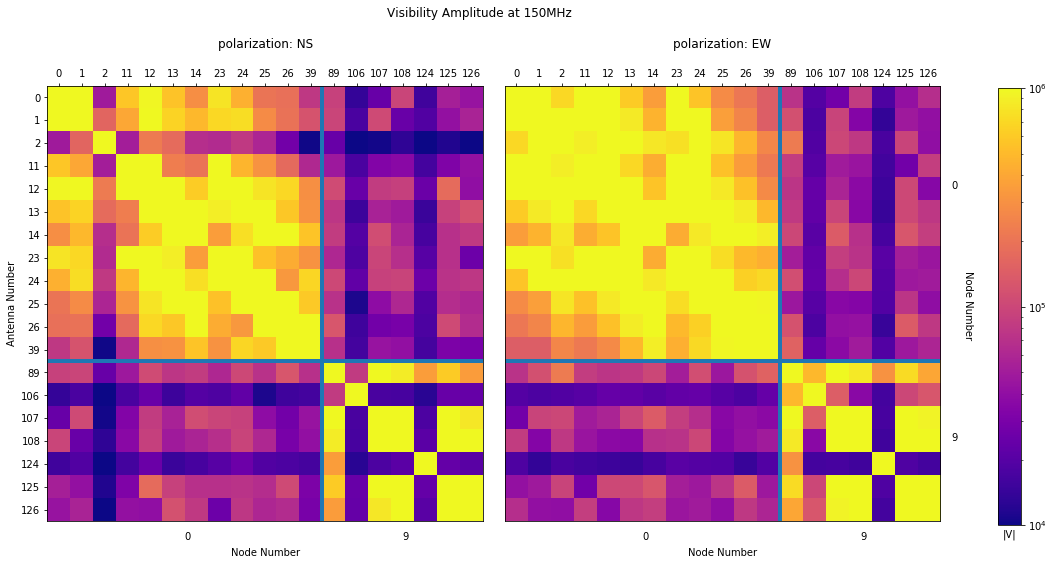

In [581]:
plotCorrMatrix_singleChannel(uv,['xx','yy'],freq=150)
#plotCorrMatrix_visAmp(uv,['xx','yy'])
# plotCorrMatrix_visAmp(uv,'xx')
#plotCorrMatrix_ReIm_multipol(uv,['xx','yy'])
#plotCorrMatrix_ReIm_multipol(uv,['xy','yx'])

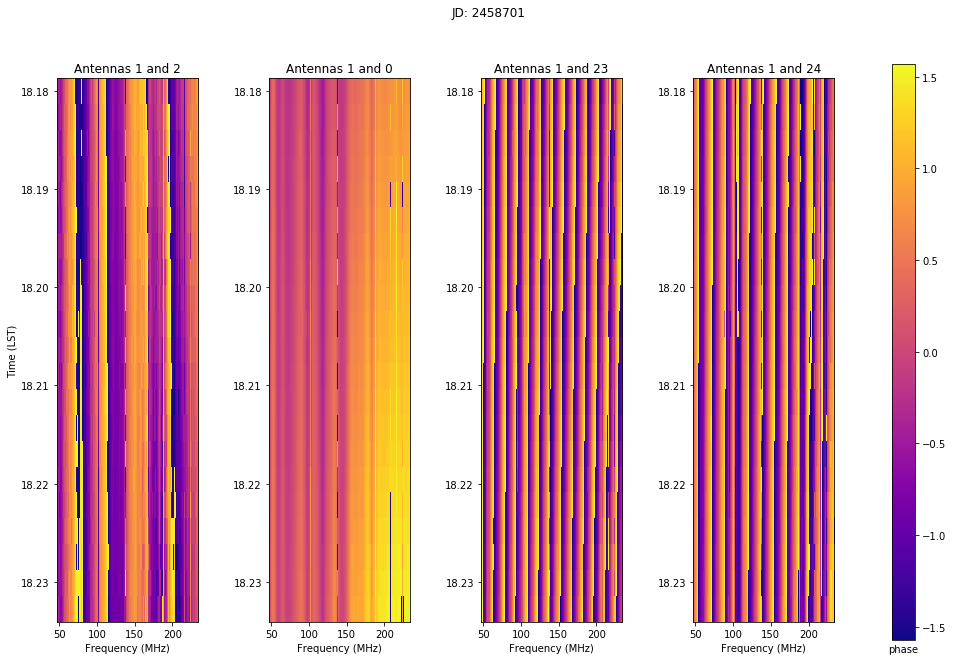

In [584]:
plotPhaseWaterfall(uv,[[1,2],[1,0],[1,23],[1,24]])
#plotAmplitudeWaterfall(uv)

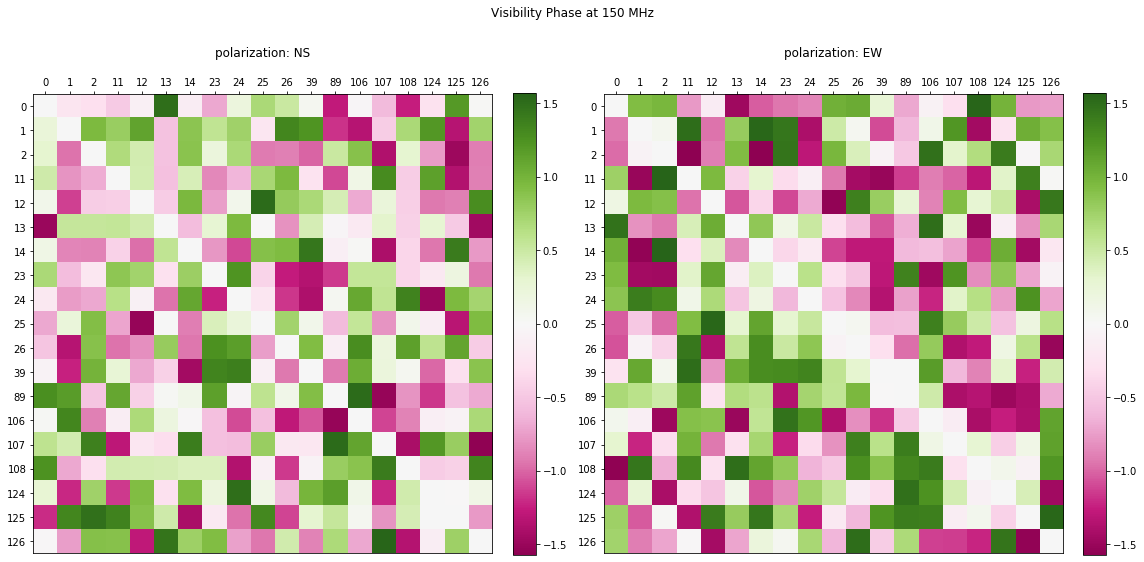

In [585]:
plotCorrMatrix_visPhase(uv,['xx','yy'],150)
#plotCorrMatrix_visPhase(uv,['xx','yy'],150,absVal=True)

In [269]:
# plotBubbles(uv,'mean',False)
# plotBubbles(uv,'median',False,marker='go')
# plotBubbles(uv,'median',True,marker='ro')
# plotBubbles(uv,'mean',True,marker='yo')

# FUNCTIONS

### DATA ACCESS

In [270]:
def get_perAntennaVis(uv,avg_method,incl_autos=False,incl_cross=True):
    perAntennaVis = {}
    pols = ['xx','yy','xy','yx']
    for i in uv.antenna_numbers:
        vis = {}
        for pol in pols:
            a = []
            for j in uv.antenna_numbers:
                if i == j and incl_autos==False:
                    continue
                if not i == j and incl_cross==False:
                    continue
                dat = uv.get_data(i,j,pol)
                if avg_method == 'mean':
                    a.append(np.mean(np.abs(dat)))
                else:
                    a.append(np.median(np.abs(dat)))
            if avg_method == 'mean':
                vis[pol] = np.mean(a)
            else:
                vis[pol] = np.median(a)
        perAntennaVis[i] = vis
    return perAntennaVis

def get_zscore(uv):
    zscores = {}
    perAntennaVis = get_perAntennaVis(uv,'mean',incl_autos=False,incl_cross=True)
    pols = ['xx','yy','xy','yx']
    for pol in pols:
        zscores[pol] = {}
        values = [perAntennaVis[i][pol] for i in perAntennaVis]
        median = np.nanmedian(values)
        medAbsDev = np.nanmedian(np.abs(values - median))
        for i in perAntennaVis:
            val = perAntennaVis[i][pol]
            zscore = 0.6745 * (val - median) / medAbsDev
            zscores[pol][i] = zscore
    return zscores

def get_zscore_antPol(uv,avg_method,incl_autos=False,incl_cross=True):
    zscores = {}
    perAntennaVis = get_perAntennaVis_antPol(uv,avg_method,incl_autos,incl_cross)
    pols = ['x','y']
    for pol in pols:
        zscores[pol] = {}
        values = [perAntennaVis[i][pol] for i in perAntennaVis]
        median = np.nanmedian(values)
        medAbsDev = np.nanmedian(np.abs(values - median))
        for i in perAntennaVis:
            val = perAntennaVis[i][pol]
            zscore = 0.6745 * (val - median) / medAbsDev
            zscores[pol][i] = zscore
    return zscores

def get_perAntennaVis_antPol(uv,avg_method,incl_autos=False,incl_cross=True):
    perAntennaVis = {}
    pols = ['xx','yy','xy','yx']
    for i in uv.antenna_numbers:
        vis = {}
        for pol in pols:
            a = []
            for j in uv.antenna_numbers:
                if i == j and incl_autos==False:
                    continue
                if not i == j and incl_cross==False:
                    continue
                dat = uv.get_data(i,j,pol)
                if avg_method == 'mean':
                    a.append(np.mean(np.abs(dat)))
                else:
                    a.append(np.median(np.abs(dat)))
            if avg_method == 'mean':
                vis[pol[0]] = np.mean(a)
            else:
                vis[pol[0]] = np.median(a)
        perAntennaVis[i] = vis
    return perAntennaVis

### BUBBLE PLOTS

In [587]:
def plotAntennaPositions(uv):
    plt.figure()
    for i in range(len(uv.antenna_positions)):
        ant = uv.antenna_positions[i]
        plt.plot(ant[1],ant[2],'bo')
        plt.text(ant[1],ant[2], uv.antenna_numbers[i])

def plotBubbles(uv,avg_method,incl_autos=False,incl_cross=True,marker='bo',alpha=0.5):
    pols=['xx','yy','xy','yx']
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axesy = [0,1,0,1]
    axesx = [0,0,1,1]
    perAntennaVis = get_perAntennaVis(uv,avg_method,incl_autos,incl_cross)
    for i in range(len(pols)):
        for j in range(len(uv.antenna_positions)):
            ant = uv.antenna_positions[j]
            xind = axesx[i]
            yind = axesy[i]
            meanvis = perAntennaVis[uv.antenna_numbers[j]][pols[i]]
            meanvis = meanvis/20000
            axs[xind][yind].plot(ant[1],ant[2],marker,markersize=meanvis,alpha=alpha)
            axs[xind][yind].text(ant[1],ant[2], uv.antenna_numbers[j])
            axs[xind][yind].set_title(pols[i])
    fig.suptitle(avg_method + ' abs(Vij) associated with each antenna, include autos: ' + str(incl_autos))
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)

def plotBubbles_zscore_antPol(uv,avg_method,incl_autos=False,incl_cross=True,marker='bo',alpha=0.5):
    zscores = get_zscore_antPol(uv,avg_method,incl_autos,incl_cross)
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    antpols = ['x','y']
    poldirs = ['N-S','E-W']
    for i in range(len(antpols)):
        for j in range(len(uv.antenna_positions)):
            ant = uv.antenna_positions[j]
            zscoreAbs = np.abs(zscores[antpols[i]][uv.antenna_numbers[j]])*10
            axs[i].plot(ant[1],ant[2],marker,markersize=zscoreAbs,alpha=alpha)
            axs[i].text(ant[1],ant[2], uv.antenna_numbers[j])
            axs[i].set_title('Antenna Polarization: ' + str(poldirs[i]))
    fig.suptitle('Modified Z-score of ' + avg_method + ' abs Vij')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    
def plotBubbles_antPol(uv,avg_method,incl_autos=False,incl_cross=True,marker='bo',alpha=0.5,normalize=False):
    antpols = ['x','y']
    poldirs = ['N-S','E-W']
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    perAntennaVis = get_perAntennaVis_antPol(uv,avg_method,incl_autos,incl_cross)
    for i in range(len(antpols)):
        for j in range(len(uv.antenna_positions)):
            ant = uv.antenna_positions[j]
            meanvis = perAntennaVis[uv.antenna_numbers[j]][antpols[i]]
            meanvis = meanvis/20000
            if normalize is True and avg_method == 'median':
                meanvis = meanvis * 7
            axs[i].plot(ant[1],ant[2],marker,markersize=meanvis,alpha=alpha)
            axs[i].text(ant[1],ant[2], uv.antenna_numbers[j])
            axs[i].set_title(poldirs[i])
    fig.suptitle(avg_method + ' abs(Vij) associated with each antenna, include autos: ' + str(incl_autos))
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

### REDUNDANCY

In [89]:
def get_redundancyMeasure(uv,pols=['xx','yy','xy','yx']):
    baseline_groups,vec_bin_centers,lengths = uv.get_redundancies(use_antpos=True,include_autos=False)
    ant_red_zscores = {}
    for ant in uv.antenna_numbers:
        ant_red_zscores[ant] = {}
        ant_red_zscores[ant]['x'] = []
        ant_red_zscores[ant]['y'] = []
    for pol in pols:
        for i in range(len(baseline_groups)):
            base_vis = []
            for j in baseline_groups[i]:
                ants = uv.baseline_to_antnums(j)
                vis = np.abs(uv.get_data(ants[0],ants[1],pol))
                medvis = np.median(vis)
                red_antpairs.append(ants)
                base_vis.append(medvis)
            for j in baseline_groups[i]:
                ants = uv.baseline_to_antnums(j)
                medvis = np.median(np.abs(uv.get_data(ants[0],ants[1],pol)))
                median = np.median(base_vis)
                medAbsDev = np.nanmedian(np.abs(base_vis - median))
                z = 0.6745 * (medvis - median) / medAbsDev
                ant_red_zscores[ants[0]][pol[0]].append(z)
                ant_red_zscores[ants[1]][pol[1]].append(z)
    return ant_red_zscores

def get_redundancyMeasure_noPol(uv):
    baseline_groups,vec_bin_centers,lengths = uv.get_redundancies(use_antpos=True,include_autos=False)
    ant_red_zscores = {}
    for ant in uv.antenna_numbers:
        ant_red_zscores[ant] = []
    for i in range(len(baseline_groups)):
        base_vis = []
        for j in baseline_groups[i]:
            ants = uv.baseline_to_antnums(j)
            vis = np.abs(uv.get_data(ants[0],ants[1]))
            medvis = np.median(vis)
            red_antpairs.append(ants)
            base_vis.append(medvis)
        for j in baseline_groups[i]:
            ants = uv.baseline_to_antnums(j)
            medvis = np.median(np.abs(uv.get_data(ants[0],ants[1])))
            median = np.median(base_vis)
            medAbsDev = np.nanmedian(np.abs(base_vis - median))
            z = 0.6745 * (medvis - median) / medAbsDev
            ant_red_zscores[ants[0]].append(z)
            ant_red_zscores[ants[1]].append(z)
    return ant_red_zscores

def plotBubbles_redundancy(uv,pol=True,marker='bo',alpha=0.5):
    if pol is True:
        antpols = ['x','y']
        poldirs = ['N-S','E-W']
        fig, axs = plt.subplots(1,2, figsize=(10,5))
        ant_red_zscores = get_redundancyMeasure(uv)
        for j in range(len(antpols)):
            for i in range(len(uv.antenna_positions)):
                antpos = uv.antenna_positions[i]
                antnum = uv.antenna_numbers[i]
                meanz = np.nanmean(np.abs(ant_red_zscores[antnum][antpols[j]]))
                axs[j].plot(antpos[1],antpos[2],marker,markersize=meanz*3,alpha=alpha)
                axs[j].text(antpos[1],antpos[2], uv.antenna_numbers[i])
                axs[j].set_title('Antenna polarization: ' + poldirs[j])
        fig.suptitle('Mean modified z-score measuring non-redundancy')
        fig.tight_layout()
        fig.subplots_adjust(top=0.85)
    if pol is False:
        ant_red_zscores = get_redundancyMeasure_noPol(uv)
        fig = plt.figure(figsize=(5,5))
        for i in range(len(uv.antenna_positions)):
            antpos = uv.antenna_positions[i]
            antnum = uv.antenna_numbers[i]
            meanz = np.nanmean(np.abs(ant_red_zscores[antnum]))
            plt.plot(antpos[1],antpos[2],marker,markersize=meanz*10,alpha=alpha)
            plt.text(antpos[1],antpos[2], uv.antenna_numbers[i])
            plt.title('Antenna polarization: averaged')

### WATERFALLS

In [574]:
def plotAmplitudeWaterfall(uv, ant_groups=[[0,23],[108,125],[0,108]]):
    fig, axs = plt.subplots(1,len(ant_groups),figsize=(16,10))
    fig.subplots_adjust(hspace=0.5,wspace=0.5)
    fig.subplots_adjust(right=0.8)
    for a in range(len(ant_groups)):
        ants = ant_groups[a]
        dat = np.abs(uv.get_data(ants[0],ants[1],'xx'))
        freqs = uv.freq_array/1000000
        time_array = uv.time_array
        loc = EarthLocation.from_geocentric(*uv.telescope_location, unit='m')
        obstime_start = Time(time_array[0],format='jd',location=loc)
        startTime = obstime_start.sidereal_time('mean').hour
        obstime_end = Time(time_array[-1],format='jd',location=loc)
        endTime = obstime_end.sidereal_time('mean').hour
        im = axs[a].imshow(dat,origin='upper', interpolation='none',cmap='plasma',
                  extent=[np.min(freqs),np.max(freqs),endTime,startTime],
                  aspect='auto',vmax=1000000,vmin=40000)
        axs[a].set_title('Antennas %i and %i' % (ants[0],ants[1]))
        axs[a].set_xlabel('Frequency (MHz)')
    axs[0].set_ylabel('Time (LST)')
    cbar_ax = fig.add_axes([0.85,0.1,0.02,0.8])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_xlabel('|V|', rotation=0)


def plotPhaseWaterfall(uv, ant_groups=[[0,23],[125,108],[23,125]]):
    fig, axs = plt.subplots(1,len(ant_groups),figsize=(16,10))
    fig.subplots_adjust(hspace=0.5,wspace=0.5)
    fig.subplots_adjust(right=0.8)
    for a in range(len(ant_groups)):
        ants = ant_groups[a]
        dat = uv.get_data(ants[0],ants[1],'xx')
        re = np.real(dat)
        imag = np.imag(dat)
        phase = np.arctan(np.divide(imag,re))
        freqs = uv.freq_array/1000000
        time_array = uv.time_array
        loc = EarthLocation.from_geocentric(*uv.telescope_location, unit='m')
        obstime_start = Time(time_array[0],format='jd',location=loc)
        startTime = obstime_start.sidereal_time('mean').hour
        obstime_end = Time(time_array[-1],format='jd',location=loc)
        endTime = obstime_end.sidereal_time('mean').hour
        im = axs[a].imshow(phase,origin='upper', interpolation='none',cmap='plasma',
                  extent=[np.min(freqs),np.max(freqs),endTime,startTime],
                  aspect='auto',vmax=np.pi/2,vmin=-np.pi/2)
        axs[a].set_title('Antennas %i and %i' % (ants[0],ants[1]))
        axs[a].set_xlabel('Frequency (MHz)')
    axs[0].set_ylabel('Time (LST)')
    cbar_ax = fig.add_axes([0.85,0.1,0.02,0.8])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_xlabel('phase', rotation=0)
    fig.suptitle('JD: 2458701')

### CORRELATION MATRICES

In [578]:
def plotCorrMatrix_visAmp(uv,pols):
    antnums = uv.antenna_numbers
    nants = len(antnums)
    power = np.empty((len(antnums),len(antnums)))
    fig, axs = plt.subplots(1,len(pols),figsize=(16,16))
    dirs = ['NS','EW']
    for p in range(len(pols)):
        pol = pols[p]
        for i in range(nants):
            for j in range(nants):
                ant1 = antnums[i]
                ant2 = antnums[j]
                dat = np.median(np.abs(uv.get_data(ant1,ant2,pol)))
                power[i,j] = dat
        pos = axs[p].imshow(power,cmap='plasma',origin='upper',extent=[0.5,nants+.5,0.5,nants+0.5],norm=LogNorm(vmin=10000, vmax=100000000))
        #ax.colorbar()
        axs[p].set_xticks(np.arange(0,nants)+1)
        axs[p].set_yticks(np.arange(nants,0,-1))
        axs[p].set_xticklabels(antnums)
        axs[p].xaxis.set_ticks_position('top')
        axs[p].set_yticklabels(antnums)
        fig.colorbar(pos,ax=axs[p],fraction=0.046, pad=0.04)
        axs[p].set_title('polarization: ' + dirs[p] + '\n')
    fig.suptitle('Visibility Amplitude - Averaged over all frequencies')
    fig.tight_layout()
    fig.subplots_adjust(top=1)
    
def plotCorrMatrix_visPhase(uv,pols=['xx','yy'],freq=150,absVal=False):
    freqs = uv.freq_array[0]
    freqind = (np.abs(freqs - freq*1000000)).argmin()
    antnums = uv.antenna_numbers
    nants = len(antnums)
    fig, axs = plt.subplots(1,len(pols),figsize=(16,16))
    dirs = ['NS','EW']
    vmin = -np.pi/2
    vmax = np.pi/2
    for p in range(len(pols)):
        pol = pols[p]
        power = np.empty((len(antnums),len(antnums)))
        for i in range(nants):
            for j in range(nants):
                ant1 = antnums[i]
                ant2 = antnums[j]
                dat = uv.get_data(ant1,ant2,pol)[10,freqind]
                re = np.real(dat)
                im = np.imag(dat)
                phase = np.arctan(np.divide(im,re))
                if absVal is True:
                    phase = np.abs(phase)
                power[i,j] = phase
        pos = axs[p].imshow(power,cmap='PiYG',origin='upper',extent=[0.5,nants+.5,0.5,nants+0.5],vmin=vmin, vmax=vmax)
        axs[p].set_xticks(np.arange(0,nants)+1)
        axs[p].set_yticks(np.arange(nants,0,-1))
        axs[p].set_xticklabels(antnums)
        axs[p].xaxis.set_ticks_position('top')
        axs[p].set_yticklabels(antnums)
        fig.colorbar(pos,ax=axs[p],fraction=0.046, pad=0.04)
        axs[p].set_title('polarization: ' + dirs[p] + '\n')
    fig.suptitle('Visibility Phase at %i MHz' % (freq))
    fig.tight_layout()
    fig.subplots_adjust(top=1.4)
    
def plotCorrMatrix_ReIm(uv,pol):
    antnums = uv.antenna_numbers
    nants = len(antnums)
    power = np.zeros((len(antnums),len(antnums)))
    for i in range(nants):
        for j in range(nants):
            ant1 = antnums[i]
            ant2 = antnums[j]
            if i < j:
                dat = np.median(np.abs(np.real(uv.get_data(ant1,ant2,pol))))
                power[i,j] = dat
            if i > j:
                dat = np.median(np.abs(np.imag(uv.get_data(ant1,ant2,pol))))
                power[i,j] = dat
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    pos = ax.imshow(power,cmap='plasma',origin='upper',extent=[0.5,nants+.5,0.5,nants+0.5],norm=LogNorm(vmin=10000, vmax=1000000))
    ax.set_xticks(np.arange(0,nants)+1)
    ax.set_yticks(np.arange(nants,0,-1))
    ax.set_xticklabels(antnums)
    ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(antnums)
    ax.set_xlabel('Real')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Imaginary')
    fig.colorbar(pos,ax=ax,fraction=0.046, pad=0.04)
    ax.set_title('Real and Imaginary, polarization: ' + str(pol) + '\n')
    
def plotCorrMatrix_ReIm_multipol(uv,pols):
    antnums = uv.antenna_numbers
    nants = len(antnums)
    power = np.zeros((len(antnums),len(antnums)))
    fig, axs = plt.subplots(1,len(pols),figsize=(16,16))
    for p in range(len(pols)):
        pol = pols[p]
        for i in range(nants):
            for j in range(nants):
                ant1 = antnums[i]
                ant2 = antnums[j]
                if i < j:
                    dat = np.median(np.abs(np.real(uv.get_data(ant1,ant2,pol))))
                    power[i,j] = dat
                if i > j:
                    dat = np.median(np.abs(np.imag(uv.get_data(ant1,ant2,pol))))
                    power[i,j] = dat
        pos = axs[p].imshow(power,cmap='plasma',origin='upper',extent=[0.5,nants+.5,0.5,nants+0.5],norm=LogNorm(vmin=10000, vmax=1000000))
        axs[p].set_xticks(np.arange(0,nants)+1)
        axs[p].set_yticks(np.arange(nants,0,-1))
        axs[p].set_xticklabels(antnums)
        axs[p].xaxis.set_ticks_position('top')
        axs[p].set_yticklabels(antnums)
        axs[p].set_xlabel('Real')
        axs[p].xaxis.set_label_position('top')
        axs[p].set_ylabel('Imaginary')
        fig.colorbar(pos,ax=axs[p],fraction=0.046, pad=0.04)
        axs[p].set_title('Real and Imaginary, polarization: ' + str(pol) + '\n')
        
# def plotCorrMatrix_redGroups(uv,pols):
#     antnums = uv.antenna_numbers
#     nants = len(antnums)
#     baseline_groups,vec_bin_centers,lengths = uv.get_redundancies(use_antpos=True,include_autos=False)
#     ngrps = len(baseline_groups)
#     power = np.zeros((len(antnums),len(antnums)))
#     fig, axs = plt.subplots(1,len(pols),figsize=(16,16))
#     for g in range(ngrps):
#         grp = baseline_groups[g]
#         print(grp)
#         for j in grp:
#             ants = uv.baseline_to_antnums(j)

def plotCorrMatrix_singleChannel(uv,pols,freq=150):
    freqs = uv.freq_array[0]
    freqind = (np.abs(freqs - freq*1000000)).argmin()
    antnums = uv.antenna_numbers
    nants = len(antnums)
    power = np.empty((len(antnums),len(antnums)))
    fig, axs = plt.subplots(1,len(pols),figsize=(16,16))
    dirs = ['NS','EW']
    for p in range(len(pols)):
        pol = pols[p]
        for i in range(nants):
            for j in range(nants):
                ant1 = antnums[i]
                ant2 = antnums[j]
                dat = np.average(np.abs(uv.get_data(ant1,ant2,pol)[:,freqind]))
                power[i,j] = dat
        im = axs[p].imshow(power,cmap='plasma',origin='upper',extent=[0.5,nants+.5,0.5,nants+0.5],norm=LogNorm(vmin=10000, vmax=1000000))
        #ax.colorbar()
        axs[p].set_xticks(np.arange(0,nants)+1)
        axs[p].set_xticklabels(antnums)
        axs[p].xaxis.set_ticks_position('top')
        #fig.colorbar(pos,ax=axs[p],fraction=0.046, pad=0.04)
        axs[p].set_title('polarization: ' + dirs[p] + '\n')
        axs[p].axhline(len(antnums)-12+.5,lw=4)
        axs[p].axvline(12+.5,lw=4)
        axs[p].text(8.5,-1,'Node Number')
        axs[p].text(16,-.3,'9')
        axs[p].text(6.5,-.3,'0')
        #ax2 = axs[p].twinx()
        #ax2.xaxis.set_ticks_position('bottom')
    axs[1].text(20.5,8.5,'Node Number',rotation=270)
    axs[1].text(20,4,'9')
    axs[1].text(20,15,'0')
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[0].set_yticks(np.arange(nants,0,-1))
    axs[0].set_yticklabels(antnums)
    axs[0].set_ylabel('Antenna Number')
    cbar_ax = fig.add_axes([0.95,0.53,0.02,0.38])
    cbar_ax.set_xlabel('|V|', rotation=0)
    cbar = fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Visibility Amplitude at %iMHz' % (freq))
    #fig.tight_layout()
    fig.subplots_adjust(top=1.32,wspace=0.05)
    

### SPECTRA

In [591]:
def plotSpectra(uv):
    fig = plt.figure()
    antnums = uv.antenna_numbers
    freqs = uv.freq_array[0]/1000000
    for ant in antnums:
        dat = np.abs(uv.get_data(ant,ant,'xx'))
        dat = dat[10,:]
        line, = plt.plot(freqs,dat)
        line.set_label(str(ant))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Visibility Amplitude')
    plt.title('Antenna Spectra')
    plt.legend(ncol=4,bbox_to_anchor=(1.1, 1.05))